In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

def process_csv_file(filename):
    """Process a single CSV file and convert timestamp to elapsed seconds."""
    # Read CSV file
    df = pd.read_csv(filename)
    
    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['Timestamp'])
    
    # Calculate elapsed time in seconds from first timestamp
    df['elapsed_time'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds()
    
    return df

def analyze_voltage_tests(files):
    """Analyze multiple voltage test files and create plots."""
    # Set plot style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Process all files
    data_frames = {}
    last_time = 0
    
    for file in files:
        try:
            df = process_csv_file(file)
            
            # Adjust elapsed time to continue from previous file
            df['elapsed_time'] += last_time
            last_time = df['elapsed_time'].iloc[-1]
            
            # Extract voltage from filename (e.g., '1_1v.csv' -> 1.1)
            voltage = float(file.split('v')[0].replace('_', '.'))
            data_frames[voltage] = df
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if not data_frames:
        print("No data to analyze!")
        return
    
    # Create output directory for plots
    output_dir = "voltage_analysis_plots"
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Combined plot
    plt.figure(figsize=(15, 8))
    
    for voltage, df in data_frames.items():
        plt.plot(df['elapsed_time'], df['Speed_KPH'], label=f'{voltage}V')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Speed (KPH)')
    plt.title('Speed vs Time for Different Voltage Settings')
    plt.legend(title='Voltage (V)')
    plt.grid(True)
    
    # Add vertical lines between voltage changes
    last_time = 0
    for voltage in data_frames.keys():
        if last_time > 0:
            plt.axvline(x=last_time, color='gray', linestyle='--', alpha=0.5)
        last_time = data_frames[voltage]['elapsed_time'].iloc[-1]
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'combined_plot.png'))
    plt.close()
    
    # 2. Individual plots
    fig, axes = plt.subplots(len(data_frames), 1, figsize=(15, 4*len(data_frames)))
    fig.suptitle('Individual Voltage Test Results', fontsize=16)
    
    for (voltage, df), ax in zip(data_frames.items(), axes if len(data_frames) > 1 else [axes]):
        ax.plot(df['elapsed_time'], df['Speed_KPH'])
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Speed (KPH)')
        ax.set_title(f'Voltage: {voltage}V')
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'individual_plots.png'))
    plt.close()
    
    # 3. Calculate and save statistics
    stats = pd.DataFrame(columns=['Voltage', 'Mean Speed', 'Max Speed', 'Min Speed', 'Std Dev'])
    
    for voltage, df in data_frames.items():
        new_stats = pd.DataFrame({
            'Voltage': [voltage],
            'Mean Speed': [df['Speed_KPH'].mean()],
            'Max Speed': [df['Speed_KPH'].max()],
            'Min Speed': [df['Speed_KPH'].min()],
            'Std Dev': [df['Speed_KPH'].std()]
        })
        stats = pd.concat([stats, new_stats], ignore_index=True)
    
    stats = stats.round(2)
    stats.to_csv(os.path.join(output_dir, 'voltage_statistics.csv'), index=False)
    
    # 4. Statistics plot
    plt.figure(figsize=(12, 6))
    
    plt.errorbar(stats['Voltage'], stats['Mean Speed'], 
                 yerr=stats['Std Dev'], 
                 fmt='o-', 
                 capsize=5,
                 label='Mean Speed ± Std Dev')
    
    plt.fill_between(stats['Voltage'], 
                     stats['Min Speed'], 
                     stats['Max Speed'], 
                     alpha=0.2,
                     label='Min-Max Range')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Speed (KPH)')
    plt.title('Speed Statistics vs Voltage')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'statistics_plot.png'))
    plt.close()
    
    print(f"\nAnalysis complete! Results saved in '{output_dir}' directory")
    print("\nStatistics Summary:")
    print(stats.to_string(index=False))

def main():
    # List of voltage test files
    files = ['1_1v.csv', '1_2v.csv', '1_3v.csv', '1_4v.csv', '1_5v.csv']
    
    # Check if files exist
    existing_files = [f for f in files if os.path.exists(f)]
    
    if not existing_files:
        print("No voltage test files found!")
        print("Expected files:", ", ".join(files))
        return
    
    print(f"Found {len(existing_files)} voltage test files")
    analyze_voltage_tests(existing_files)

if __name__ == "__main__":
    main()

Found 5 voltage test files


/tmp/ipykernel_78641/4230948787.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')



Analysis complete! Results saved in 'voltage_analysis_plots' directory

Statistics Summary:
 Voltage  Mean Speed  Max Speed  Min Speed  Std Dev
     1.1        4.13       7.53        0.0     3.36
     1.2        8.95      12.52        0.0     4.54
     1.3       24.88      34.84        0.0    10.29
     1.4       28.60      50.01        0.0    19.06
     1.5       39.72      55.81        0.0    16.96


In [1]:
import pandas as pd
from datetime import datetime
import os

def merge_voltage_files(files):
    """Merge multiple voltage test CSV files with continuous timing."""
    # Initialize empty list to store dataframes
    dfs = []
    last_time = 0
    
    for file in sorted(files):  # Sort to ensure consistent order
        try:
            # Read CSV file
            df = pd.read_csv(file)
            
            # Convert timestamp to datetime
            df['datetime'] = pd.to_datetime(df['Timestamp'])
            
            # Calculate elapsed time in seconds from first timestamp
            df['elapsed_time'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds()
            
            # Adjust elapsed time to continue from previous file
            df['elapsed_time'] += last_time
            last_time = df['elapsed_time'].iloc[-1]
            
            # Extract voltage from filename (e.g., '1_1v.csv' -> 1.1)
            voltage = float(file.split('v')[0].replace('_', '.'))
            df['Voltage'] = voltage
            
            dfs.append(df)
            print(f"Processed {file} - Duration: {df['elapsed_time'].iloc[-1] - df['elapsed_time'].iloc[0]:.2f}s")
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if not dfs:
        raise ValueError("No data to merge!")
    
    # Concatenate all dataframes
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Sort by elapsed time to ensure proper ordering
    merged_df = merged_df.sort_values('elapsed_time').reset_index(drop=True)
    
    # Save merged data
    output_file = 'merged_voltage_tests.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"\nMerged data saved to {output_file}")
    print(f"Total duration: {merged_df['elapsed_time'].iloc[-1]:.2f} seconds")
    
    return merged_df

def main():
    # List of voltage test files
    files = ['1_1v.csv', '1_2v.csv', '1_3v.csv', '1_4v.csv', '1_5v.csv']
    
    # Check if files exist
    existing_files = [f for f in files if os.path.exists(f)]
    
    if not existing_files:
        print("No voltage test files found!")
        print("Expected files:", ", ".join(files))
        return
    
    print(f"Found {len(existing_files)} voltage test files")
    merge_voltage_files(existing_files)

if __name__ == "__main__":
    main()

Found 5 voltage test files
Processed 1_1v.csv - Duration: 29.83s
Processed 1_2v.csv - Duration: 71.44s
Processed 1_3v.csv - Duration: 99.30s
Processed 1_4v.csv - Duration: 95.90s
Processed 1_5v.csv - Duration: 74.91s

Merged data saved to merged_voltage_tests.csv
Total duration: 371.38 seconds


In [2]:
import pandas as pd
import os

def reformat_voltage_data(files):
    """Reformat voltage test CSV files into simplified format with continuous timing."""
    dfs = []
    last_time = 0
    
    for file in sorted(files):  # Sort to ensure consistent order
        try:
            # Read CSV file
            df = pd.read_csv(file)
            
            # Calculate elapsed time and adjust to continue from previous file
            df['datetime'] = pd.to_datetime(df['Timestamp'])
            df['elapsed_time'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds()
            df['elapsed_time'] += last_time
            last_time = df['elapsed_time'].iloc[-1]
            
            # Select and rename columns
            df_formatted = df[['elapsed_time', 'Voltage_Out1', 'Voltage_Out2', 'Speed_KPH']]
            df_formatted.columns = ['time', 'voltage_out1', 'voltage_out2', 'speed_kph']
            
            dfs.append(df_formatted)
            print(f"Processed {file}")
            
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if not dfs:
        raise ValueError("No data to merge!")
    
    # Concatenate all dataframes
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Sort by time to ensure proper ordering
    merged_df = merged_df.sort_values('time').reset_index(drop=True)
    
    # Round time to 3 decimal places for clarity
    merged_df['time'] = merged_df['time'].round(3)
    
    # Save reformatted data
    output_file = 'voltage_data_reformatted.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"\nReformatted data saved to {output_file}")
    print(f"Total duration: {merged_df['time'].iloc[-1]:.3f} seconds")
    
    return merged_df

def main():
    # List of voltage test files
    files = ['1_1v.csv', '1_2v.csv', '1_3v.csv', '1_4v.csv', '1_5v.csv']
    
    # Check if files exist
    existing_files = [f for f in files if os.path.exists(f)]
    
    if not existing_files:
        print("No voltage test files found!")
        print("Expected files:", ", ".join(files))
        return
    
    print(f"Found {len(existing_files)} voltage test files")
    reformat_voltage_data(existing_files)

if __name__ == "__main__":
    main()

Found 5 voltage test files
Processed 1_1v.csv
Processed 1_2v.csv
Processed 1_3v.csv
Processed 1_4v.csv
Processed 1_5v.csv

Reformatted data saved to voltage_data_reformatted.csv
Total duration: 371.382 seconds


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_voltage_speed_data(data_file):
    """Create plots for voltage and speed data."""
    # Read the data
    df = pd.read_csv(data_file)
    
    # Set the style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle('Voltage and Speed Analysis', fontsize=14)
    
    # Plot voltages
    ax1.plot(df['time'], df['voltage_out1'], label='Voltage Out 1', color='#2ecc71')
    ax1.plot(df['time'], df['voltage_out2'], label='Voltage Out 2', color='#e74c3c')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_title('Voltage Outputs Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Plot speed
    ax2.plot(df['time'], df['speed_kph'], color='#3498db', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Speed (KPH)')
    ax2.set_title('Speed Over Time')
    ax2.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig('voltage_speed_analysis.png')
    print("Plot saved as 'voltage_speed_analysis.png'")
    
    # Show statistics
    print("\nData Statistics:")
    print("\nVoltage Out 1:")
    print(f"Mean: {df['voltage_out1'].mean():.3f}V")
    print(f"Min: {df['voltage_out1'].min():.3f}V")
    print(f"Max: {df['voltage_out1'].max():.3f}V")
    
    print("\nVoltage Out 2:")
    print(f"Mean: {df['voltage_out2'].mean():.3f}V")
    print(f"Min: {df['voltage_out2'].min():.3f}V")
    print(f"Max: {df['voltage_out2'].max():.3f}V")
    
    print("\nSpeed:")
    print(f"Mean: {df['speed_kph'].mean():.3f} KPH")
    print(f"Min: {df['speed_kph'].min():.3f} KPH")
    print(f"Max: {df['speed_kph'].max():.3f} KPH")
    
    plt.show()

/tmp/ipykernel_14145/395115418.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Plot saved as 'voltage_speed_analysis.png'

Data Statistics:

Voltage Out 1:
Mean: 1.287V
Min: 1.000V
Max: 1.500V

Voltage Out 2:
Mean: 0.644V
Min: 0.500V
Max: 0.750V

Speed:
Mean: 24.224 KPH
Min: 0.000 KPH
Max: 55.810 KPH


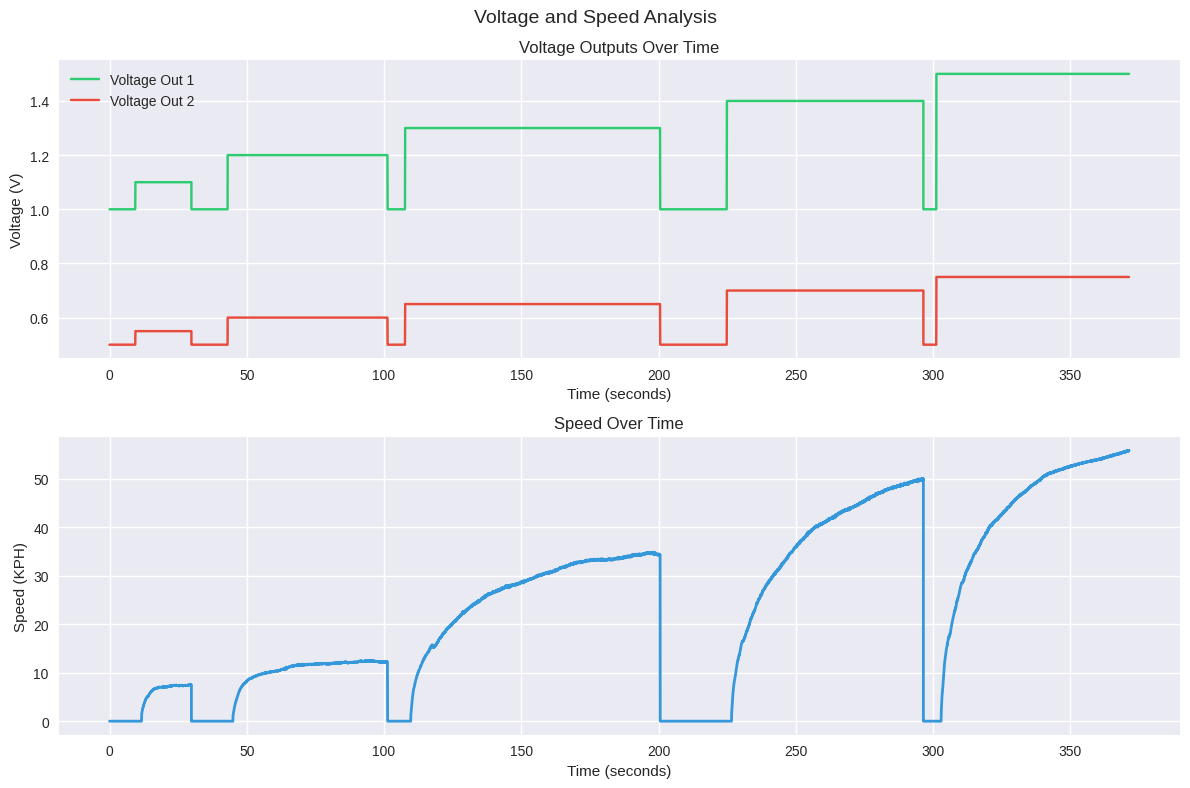

In [4]:

# Run the plotting function
plot_voltage_speed_data('voltage_data_reformatted.csv')  # Replace with your actual filename

/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/tmp/ipykernel_33303/423746586.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will

Plot saved as 'voltage_speed_accel_analysis.png'
Updated data saved to 'voltage_data_with_acceleration.csv'

Data Statistics:

Voltage Out 1:
Mean: 1.287V
Min: 1.000V
Max: 1.500V

Voltage Out 2:
Mean: 0.644V
Min: 0.500V
Max: 0.750V

Speed:
Mean: 24.224 KPH
Min: 0.000 KPH
Max: 55.810 KPH

Acceleration:
Mean: 0.272 KPH/s
Min: -732.218 KPH/s
Max: 24.682 KPH/s


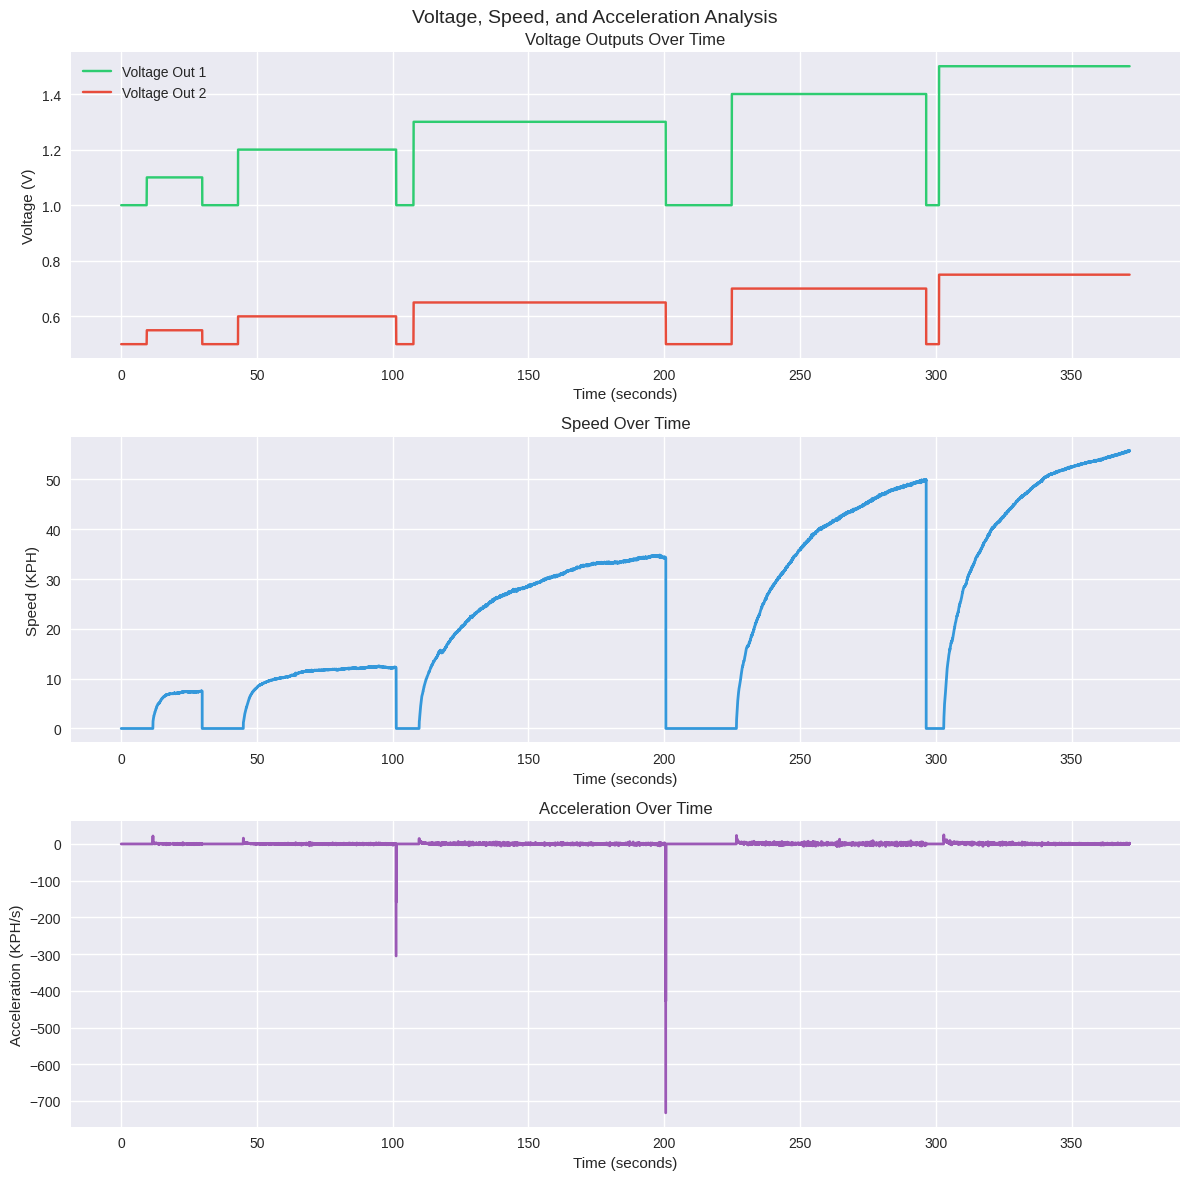

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_voltage_speed_accel_data(data_file):
    """Create plots for voltage, speed, and acceleration data."""
    # Read the data
    df = pd.read_csv(data_file)
    
    # Calculate acceleration (derivative of speed)
    # Using central difference method: (v[i+1] - v[i-1]) / (t[i+1] - t[i-1])
    df['acceleration'] = np.gradient(df['speed_kph'], df['time'])
    
    # Set the style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle('Voltage, Speed, and Acceleration Analysis', fontsize=14)
    
    # Plot voltages
    ax1.plot(df['time'], df['voltage_out1'], label='Voltage Out 1', color='#2ecc71')
    ax1.plot(df['time'], df['voltage_out2'], label='Voltage Out 2', color='#e74c3c')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_title('Voltage Outputs Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Plot speed
    ax2.plot(df['time'], df['speed_kph'], color='#3498db', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Speed (KPH)')
    ax2.set_title('Speed Over Time')
    ax2.grid(True)
    
    # Plot acceleration
    ax3.plot(df['time'], df['acceleration'], color='#9b59b6', linewidth=2)
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Acceleration (KPH/s)')
    ax3.set_title('Acceleration Over Time')
    ax3.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig('voltage_speed_accel_analysis.png')
    print("Plot saved as 'voltage_speed_accel_analysis.png'")
    
    # Save updated CSV with acceleration data
    output_file = 'voltage_data_with_acceleration.csv'
    df.to_csv(output_file, index=False)
    print(f"Updated data saved to '{output_file}'")
    
    # Show statistics
    print("\nData Statistics:")
    print("\nVoltage Out 1:")
    print(f"Mean: {df['voltage_out1'].mean():.3f}V")
    print(f"Min: {df['voltage_out1'].min():.3f}V")
    print(f"Max: {df['voltage_out1'].max():.3f}V")
    
    print("\nVoltage Out 2:")
    print(f"Mean: {df['voltage_out2'].mean():.3f}V")
    print(f"Min: {df['voltage_out2'].min():.3f}V")
    print(f"Max: {df['voltage_out2'].max():.3f}V")
    
    print("\nSpeed:")
    print(f"Mean: {df['speed_kph'].mean():.3f} KPH")
    print(f"Min: {df['speed_kph'].min():.3f} KPH")
    print(f"Max: {df['speed_kph'].max():.3f} KPH")
    
    print("\nAcceleration:")
    print(f"Mean: {df['acceleration'].mean():.3f} KPH/s")
    print(f"Min: {df['acceleration'].min():.3f} KPH/s")
    print(f"Max: {df['acceleration'].max():.3f} KPH/s")
    
    plt.show()

# Run the plotting function
plot_voltage_speed_accel_data('voltage_data_reformatted.csv')  # Replace with your actual filename

/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/irman/anaconda3/envs/zed_sdk/lib/python3.8/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/tmp/ipykernel_33303/376408246.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will

Updated data saved to 'voltage_data_with_smooth_acceleration.csv'

Acceleration Statistics (excluding zeros):
Mean: 0.518 KPH/s
Min: -3.296 KPH/s
Max: 16.150 KPH/s


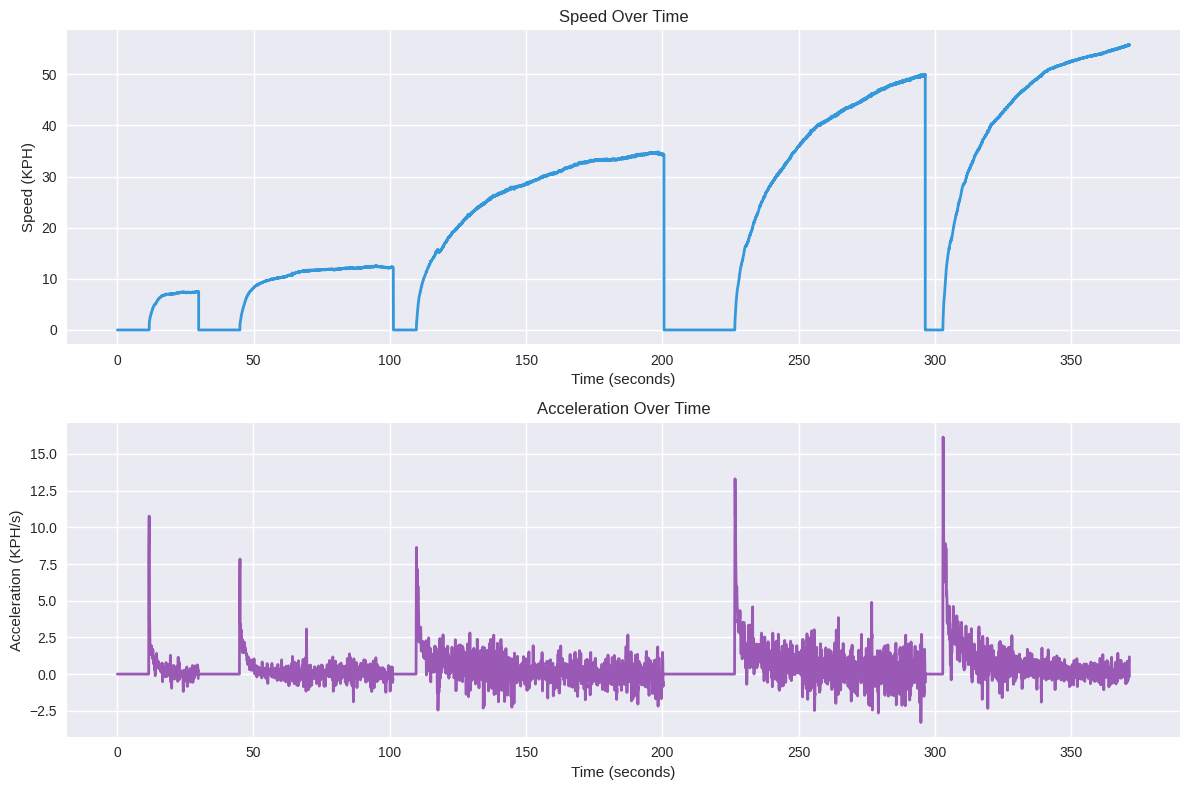

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_smooth_acceleration(df, speed_col='speed_kph', time_col='time', threshold=50):
    """Calculate acceleration with outlier removal and smoothing."""
    # Calculate raw acceleration
    accel = np.gradient(df[speed_col], df[time_col])
    
    # Remove extreme values
    accel = np.where(np.abs(accel) > threshold, 0, accel)
    
    # Optional: Apply moving average smoothing
    window_size = 5
    accel = pd.Series(accel).rolling(window=window_size, center=True).mean()
    
    return accel

def plot_voltage_speed_accel_data(data_file):
    """Create plots for voltage, speed, and smoothed acceleration data."""
    # Read the data
    df = pd.read_csv(data_file)
    
    # Calculate smoothed acceleration
    df['acceleration'] = calculate_smooth_acceleration(df)
    
    # Set the style
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot speed
    ax1.plot(df['time'], df['speed_kph'], color='#3498db', linewidth=2)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Speed (KPH)')
    ax1.set_title('Speed Over Time')
    ax1.grid(True)
    
    # Plot smoothed acceleration
    ax2.plot(df['time'], df['acceleration'], color='#9b59b6', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Acceleration (KPH/s)')
    ax2.set_title('Acceleration Over Time')
    ax2.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save updated CSV with smoothed acceleration data
    output_file = 'voltage_data_with_smooth_acceleration.csv'
    df.to_csv(output_file, index=False)
    print(f"Updated data saved to '{output_file}'")
    
    # Show statistics for non-zero acceleration
    valid_accel = df['acceleration'].dropna()
    valid_accel = valid_accel[valid_accel != 0]
    
    print("\nAcceleration Statistics (excluding zeros):")
    print(f"Mean: {valid_accel.mean():.3f} KPH/s")
    print(f"Min: {valid_accel.min():.3f} KPH/s")
    print(f"Max: {valid_accel.max():.3f} KPH/s")
    
    plt.show()

# Run the plotting function
plot_voltage_speed_accel_data('voltage_data_reformatted.csv')  # Replace with your actual filename

In [9]:
# Convert string to DataFrame
df = pd.read_csv("1_5v.csv")

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculate time from start in seconds
start_time = df['Timestamp'].min()
df['Time'] = (df['Timestamp'] - start_time).dt.total_seconds()

# Reorder columns
result = df[['Time', 'Voltage_Out1', 'Voltage_Out2', 'Speed_KPH']]

# Save to CSV file
result.to_csv('1_5v_cleaned.csv', index=False)
print("Data saved to 1_5v_cleaned.csv")

Data saved to 1_5v_cleaned.csv
